In [1]:
import os
import time

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

print("Package is ready.")

Package is ready.


In [2]:
matplotlib.rcParams['figure.figsize'] = ((8/2.54)*2, (6/2.54)*2)
plt.rcParams["font.family"] = "arial"
plt.rcParams["font.serif"] = "arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 15})
MARKER_SIZE = 3
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5"]

In [3]:
N_FOLD = 5
TIME_STEP = 144
OUTPUT_SIZE = 24
INTERVAL = pd.Timedelta("10 min")
pred_results = []
#PRED_COL = ['temp', 'rh', 'ec', 'co2', 'atm', 'uv', 'rad', 's_temp', 's_rh']
PRED_COL = ['temp', 'rh', 'co2', 'rad', 's_temp', 's_rh']

In [4]:
N_FOLD =10
TIME_STEP = 12
INTERVAL = pd.Timedelta("10 min")
pred_results = []

# Growth Environment

In [4]:
env_df = pd.read_csv("./results/forced_env.csv", index_col="Unnamed: 0")
env_df.index = pd.DatetimeIndex(env_df.index)

In [5]:
weather_env = env_df[[col for col in env_df.columns if '.w' in col]].copy()
soil_env = env_df[[col for col in env_df.columns if 's_' in col]].copy()
env_df.drop([col for col in env_df.columns if '.w' in col], axis=1, inplace=True)
env_df.drop([col for col in env_df.columns if 's_' in col], axis=1, inplace=True)

In [6]:
__ = []
_ = env_df[[col for col in env_df.columns if 'temp' in col]].mean(axis=1); _.name = "temp"; __.append(pd.DataFrame(_))
_ = env_df[[col for col in env_df.columns if 'rh' in col]].mean(axis=1); _.name = "rh"; __.append(pd.DataFrame(_))
_ = env_df[[col for col in env_df.columns if 'ec' in col]].mean(axis=1); _.name = "EC"; __.append(pd.DataFrame(_))
_ = env_df[[col for col in env_df.columns if 'co2' in col]].mean(axis=1); _.name = "CO2"; __.append(pd.DataFrame(_))
_ = env_df[[col for col in env_df.columns if 'atm' in col]].mean(axis=1); _.name = "atm"; __.append(pd.DataFrame(_))
_ = env_df[[col for col in env_df.columns if 'uv' in col]].mean(axis=1); _.name = "UV"; __.append(pd.DataFrame(_))
_ = env_df[[col for col in env_df.columns if 'rad' in col]].mean(axis=1); _.name = "rad"; __.append(pd.DataFrame(_))
env_mean = pd.concat(__, axis=1)

In [7]:
__ = []
_ = soil_env[[col for col in soil_env.columns if 'temp' in col]].mean(axis=1); _.name = "temp"; __.append(pd.DataFrame(_))
_ = soil_env[[col for col in soil_env.columns if 'rh' in col]].mean(axis=1); _.name = "rh"; __.append(pd.DataFrame(_))
soil_env_mean = pd.concat(__, axis=1)

In [8]:
env_date = pd.date_range(env_mean.index[0], env_df.index[-1], freq="10min")

In [9]:
#Dropping outlier
__ = env_mean[["rad"]].copy()
env_mean = env_mean[np.abs(env_mean-env_mean.mean())<=(3*env_mean.std())]
#env_df.loc["2018-01-21 11:50:00", "RootTemp(1)"] = pd.np.nan
env_df["rad"] = __

## Greenhouse

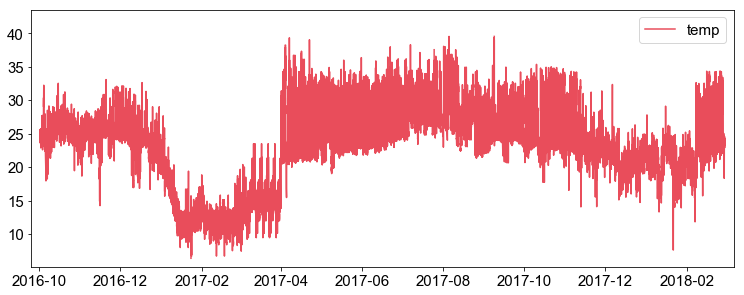

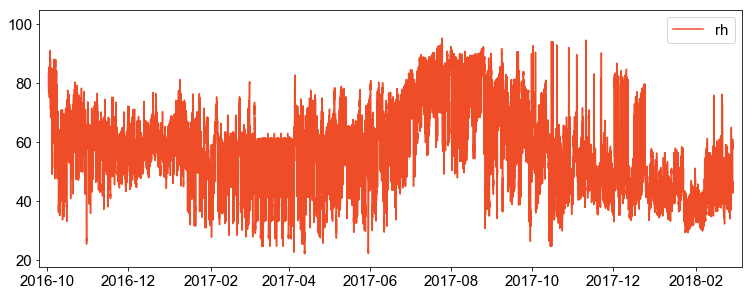

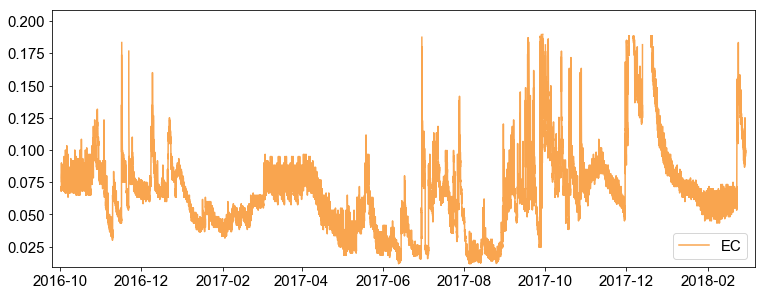

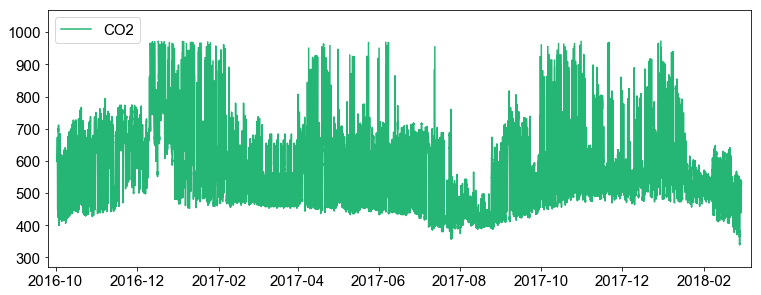

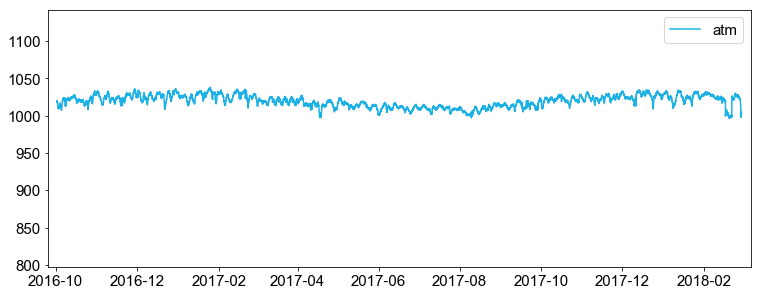

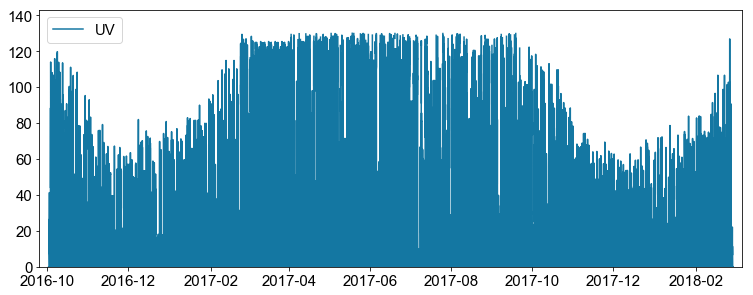

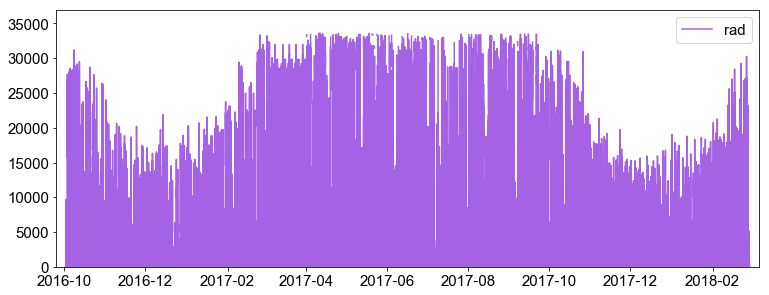

In [10]:
for _ in range(env_mean.shape[1]):
    plt.figure(figsize=((8/2.54)*4, (6/2.54)*2))
    line = plt.plot(env_mean.index, env_mean.iloc[:, _], c=cmap[_], label = env_mean.columns[_])
    plt.legend(handles=line)
    plt.axis([env_mean.index[0] - pd.Timedelta('7d'), env_mean.index[-1] + pd.Timedelta('7d'),
              env_mean.iloc[:, _].min() - abs(env_mean.iloc[:, _].min()*0.2), env_mean.iloc[:, _].max()*1.1])
    plt.show()

## Weather

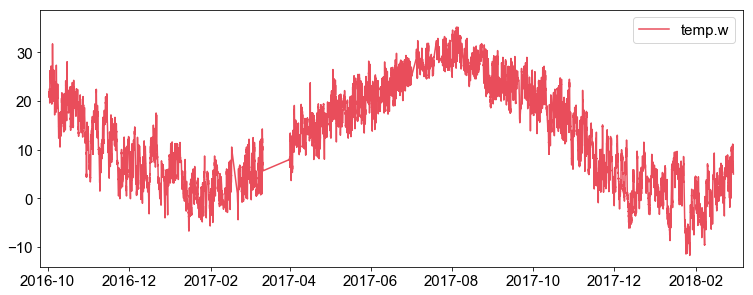

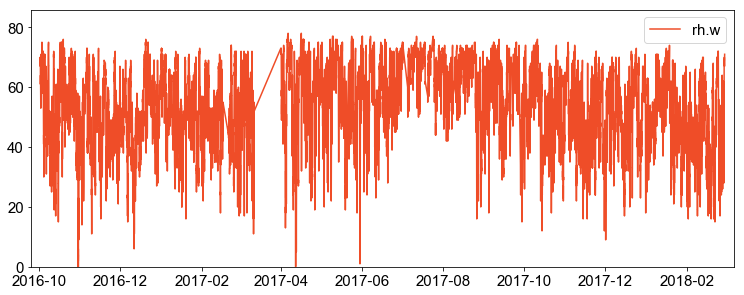

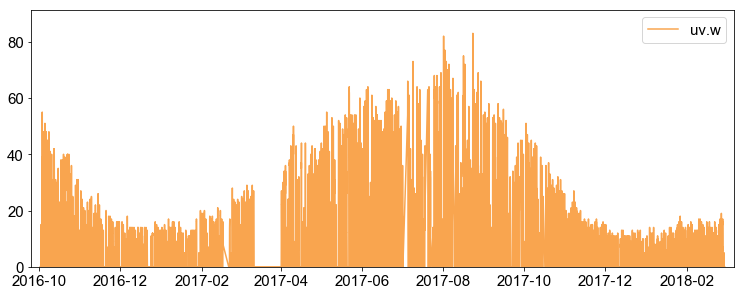

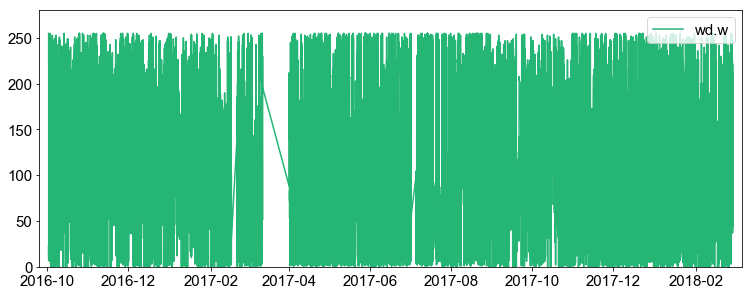

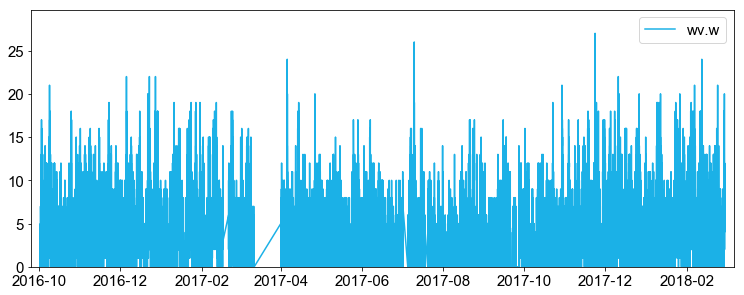

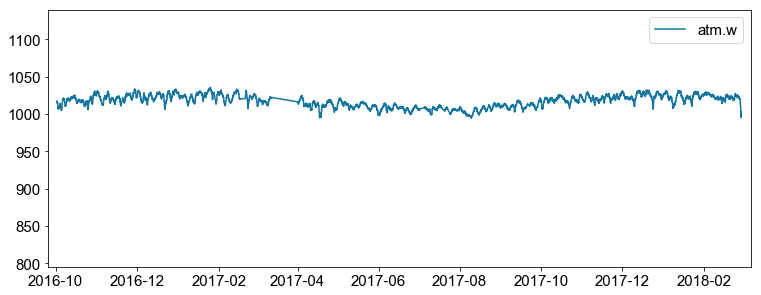

In [11]:
for _ in range(weather_env.shape[1]):
    plt.figure(figsize=((8/2.54)*4, (6/2.54)*2))
    line = plt.plot(weather_env.index, weather_env.iloc[:, _], c=cmap[_], label = weather_env.columns[_])
    plt.legend(handles=line)
    plt.axis([weather_env.index[0] - pd.Timedelta('7d'), weather_env.index[-1] + pd.Timedelta('7d'),
              weather_env.iloc[:, _].min() - abs(weather_env.iloc[:, _].min()*0.2), weather_env.iloc[:, _].max()*1.1])
    plt.show()

## Soil

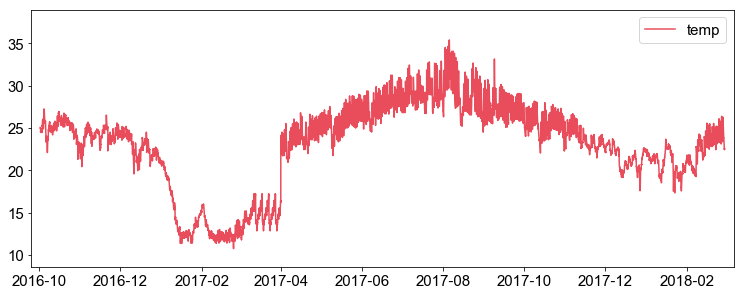

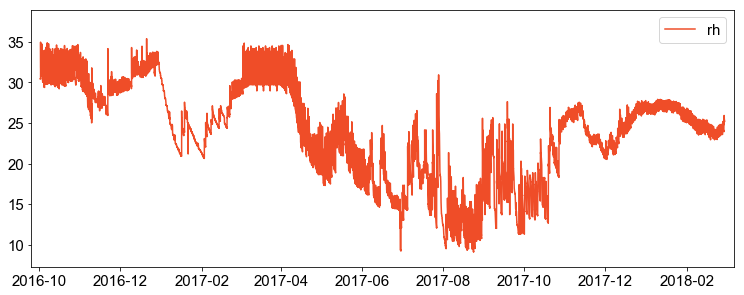

In [12]:
for _ in range(soil_env_mean.shape[1]):
    plt.figure(figsize=((8/2.54)*4, (6/2.54)*2))
    line = plt.plot(soil_env_mean.index, soil_env_mean.iloc[:, _], c=cmap[_], label = soil_env_mean.columns[_])
    plt.legend(handles=line)
    plt.axis([soil_env_mean.index[0] - pd.Timedelta('7d'), soil_env_mean.index[-1] + pd.Timedelta('7d'),
              soil_env_mean.iloc[:, _].min() - abs(soil_env_mean.iloc[:, _].min()*0.2), soil_env_mean.iloc[:, _].max()*1.1])
    plt.show()

# Prediction Results

In [6]:
pred_df = pd.read_csv("./results/output_CO2_LSTM_T144_I10 min_F1.CSV", index_col="Unnamed: 0")
pred_label = pd.read_csv("./results/labels_CO2_LSTM_T144_I10 min_F1.CSV", index_col=["Unnamed: 0"])
pred_df.index = pd.DatetimeIndex(pred_df.index)
pred_label.index = pd.DatetimeIndex(pred_label.index)

In [15]:
COLUMNS = []
for i in range(pred_df.shape[1]):
    COLUMNS.append(INTERVAL*i)
pred_df.columns = COLUMNS
pred_label.columns = COLUMNS

In [16]:
predictions = []
pred_labels = []
for i in range(pred_df.shape[0]):
    temp = pred_df.iloc[i, :].copy()
    temp.index += pred_df.index[i]
    temp = pd.DataFrame(temp)
    temp.columns = ["CO2"]
    predictions.append(temp)
    
    temp = pred_label.iloc[i, :].copy()
    temp.index += pred_label.index[i]
    temp = pd.DataFrame(temp)
    temp.columns = ["CO2"]
    pred_labels.append(temp)
    
    if i % 10000 == 0:
        print("%d processed..." % i)

0 processed...
10000 processed...
20000 processed...


In [17]:
predictions = pd.concat(predictions, axis=1)

In [18]:
pred_label = pd.concat(pred_labels, axis=1)

In [19]:
pred_means = predictions.mean(axis=1, skipna=True)
pred_maxs = predictions.max(axis=1, skipna=True)
pred_mins = predictions.min(axis=1, skipna=True)

In [20]:
label_means = pred_label.mean(axis=1, skipna=True)

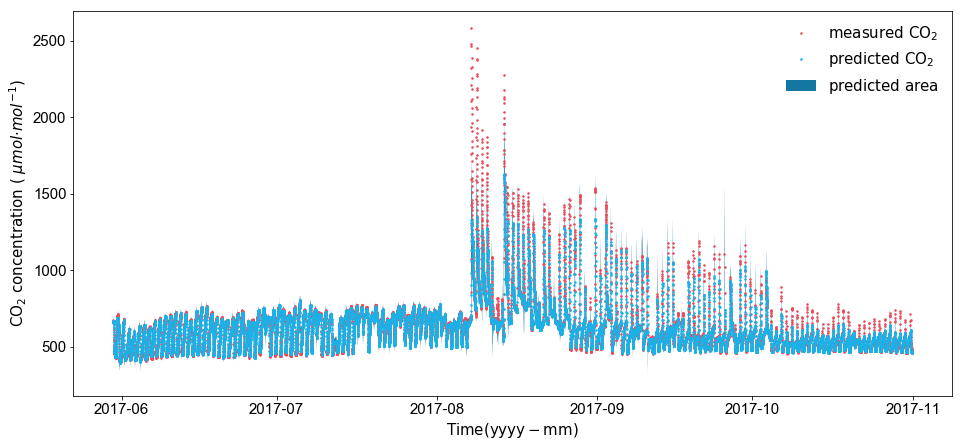

In [111]:
x_date = predictions.index
#LL = 9000

plt.figure(figsize=((8/2.54)*5, (6/2.54)*3))

plt.fill_between(x_date, pred_mins, pred_maxs, facecolor=cmap[-2], alpha=1)

linear_label = plt.plot(x_date, label_means, "o", markersize=MARKER_SIZE / 2, c=cmap[0])
linear_mean = plt.plot(x_date, pred_means, "o", markersize=MARKER_SIZE / 2, c=cmap[4])


plt.legend(["$measured\ CO_{2}$", "$predicted\ CO_{2}$", "$predicted\ area$"], bbox_to_anchor=(1, 1), frameon=False)
plt.xlabel("$Time (yyyy-mm)$")
#plt.xlabel("Time (MM-dd hh)")
plt.ylabel("$CO_2\ concentration\ \mathit{(\ {\mu}mol{\cdot}mol^{-1})}$")
#plt.axis([x_date[3000] - pd.Timedelta('2d'), x_date[3000] + pd.Timedelta('2d'), 300, 1000])
plt.savefig("./test.pdf", format="pdf")
plt.show()

In [54]:
pred_squences = []
for i in range(TIME_STEP-1):
    pred_squences.append(pd.DataFrame(((predictions.iloc[i:-11+i,:] * np.identity(22233)).replace(0, np.nan)).mean(axis=1, skipna=True)))
pred_squences.append(pd.DataFrame(((predictions.iloc[11:,:] * np.identity(22233)).replace(0, np.nan)).mean(axis=1, skipna=True)))
pred_squences = pd.concat(pred_squences, axis=1)

In [74]:
x_date[5]

Timestamp('2017-05-30 10:50:00', freq='10T')

In [88]:
pred_squences.shape

(22244, 12)

In [103]:
for i in range(5,0,-1):
    print(i)

5
4
3
2
1


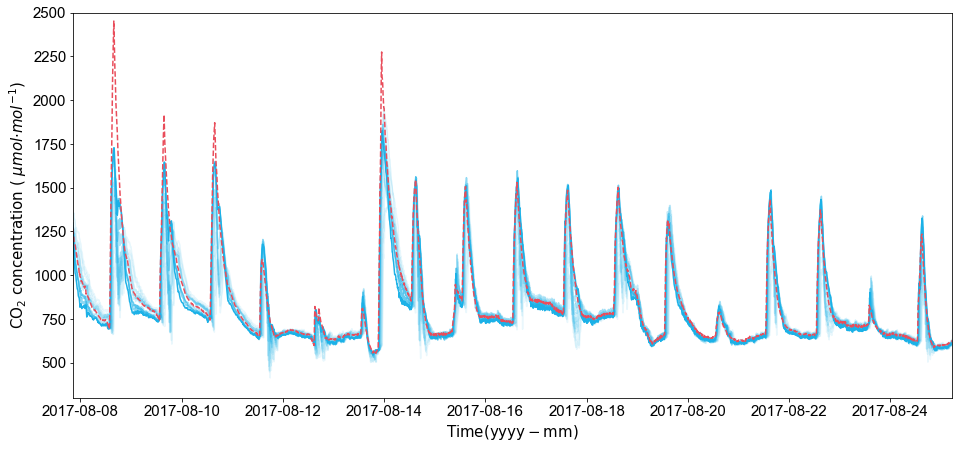

In [123]:
x_date = predictions.index
#LL = 9000

plt.figure(figsize=((8/2.54)*5, (6/2.54)*3))

#plt.fill_between(x_date, pred_mins, pred_maxs, facecolor=cmap[-2], alpha=1)

for i in range(pred_squences.shape[1]-1,-1,-1):
    linear_sq = plt.plot(x_date, pred_squences.iloc[:,i], "-", c=cmap[4], alpha=1/(i+0.01))
#linear_sq1 = plt.plot(x_date, pred_squences.iloc[:,0], "-", c=cmap[3], alpha=1)
#linear_sq12 = plt.plot(x_date, pred_squences.iloc[:,11], "-", c=cmap[-1], alpha=1)
linear_label = plt.plot(x_date, label_means, "--", markersize=MARKER_SIZE / 2, c=cmap[0])

#plt.legend(["$measured\ CO_{2}$", "$predicted\ CO_{2}$", "$predicted\ area$"], bbox_to_anchor=(1, 1), frameon=False)
plt.xlabel("$Time (yyyy-mm)$")
plt.ylabel("$CO_2\ concentration\ \mathit{(\ {\mu}mol{\cdot}mol^{-1})}$")
plt.axis([x_date[10000], x_date[12500], 300, 2500])
#plt.savefig("./test.pdf", format="pdf")
plt.show()

In [ ]:
x_date = pred_means.index

plt.figure(figsize=((8/2.54)*5, (6/2.54)*3))

linear_label = plt.plot(x_date, label_means, "-", c=cmap[0])
linear_mean = plt.plot(x_date, pred_means, "-", c=cmap[-2])


plt.legend(["$CO_2$"], bbox_to_anchor=(1.02, 1))
plt.xlabel("Time")
plt.ylabel("$CO_2$ concentration (ppm)")
plt.axis([x_date[0] - pd.Timedelta('2d'), x_date[-1] + pd.Timedelta('2d'), 300, 1500])
plt.show()

In [ ]:
min_ = min(pred_result.min())
max_ = max(pred_result.max())
x_linear = np.arange(min_ - 5, max_ + 5)
y_linear = x_linear


linear = plt.plot(x_linear, y_linear, "k-")
for _ in range(6):
    scatter = plt.scatter(pred_result.iloc[:, _], pred_result.iloc[:, _+6], s=MARKER_SIZE*5, c=cmap[_])
    

plt.legend(["1:1", "K", "Ca", "Mg", "S", "N", "P"])
plt.xlabel("Measured ion concentration (meq)")
plt.ylabel("Estimated ion concentration (meq)")
plt.axis([min_ - 5, max_ + 5, min_ - 5, max_ + 5])
plt.show()

In [ ]:
x_date = pred_result.index

plt.figure(figsize=((8/2.54)*5, (6/2.54)*3))
for _ in range(6):
    #scatter_gt = plt.scatter(x_date, pred_result.iloc[:, _], s=MARKER_SIZE, c=cmap[_])
    #scatter_pred = plt.scatter(x_date, pred_result.iloc[:, _+6], s=MARKER_SIZE, c=cmap[_])
    linear = plt.plot(x_date, pred_result.iloc[:, _], "o--", markersize = MARKER_SIZE*2, c=cmap_m[_])
    linear_pred = plt.plot(x_date, pred_result.iloc[:, _+6], "o-", markersize = MARKER_SIZE*2, c=cmap[_])

plt.legend(["$K_m$", "$K_e$", "$Ca_m$", "$Ca_e$", "$Mg_m$", "$Mg_e$", "$S_m$", "$S_e$", "$N_m$", "$N_e$", "$P_m$", "$P_e$"], bbox_to_anchor=(1.02, 1))
plt.xlabel("Time")
plt.ylabel("Ion concentration (meq)")
plt.axis([x_date[0] - pd.Timedelta('2d'), x_date[-1] + pd.Timedelta('2d'), min_ - 5, max_ + 5])
plt.show()

In [ ]:
x_date = pred_result.index

plt.figure(figsize=((8/2.54)*5, (6/2.54)*3))
for _ in [0,1,2,3,5]:
    #scatter_gt = plt.scatter(x_date, pred_result.iloc[:, _], s=MARKER_SIZE, c=cmap[_])
    #scatter_pred = plt.scatter(x_date, pred_result.iloc[:, _+6], s=MARKER_SIZE, c=cmap[_])
    linear = plt.plot(x_date, pred_result.iloc[:, _], "o--", markersize = MARKER_SIZE*2, c=cmap_m[_])
    linear_pred = plt.plot(x_date, pred_result.iloc[:, _+6], "o-", markersize = MARKER_SIZE*2, c=cmap[_])

plt.legend(["$K_m$", "$K_e$", "$Ca_m$", "$Ca_e$", "$Mg_m$", "$Mg_e$", "$S_m$", "$S_e$", "$P_m$", "$P_e$"], bbox_to_anchor=(1.02, 1))
plt.xlabel("Time")
plt.ylabel("Ion concentration (meq)")
plt.axis([x_date[0] - pd.Timedelta('2d'), x_date[-1] + pd.Timedelta('2d'), min_ - 5, max_ + 5])
plt.show()

In [ ]:
x_date = pred_result.index

plt.figure(figsize=((8/2.54)*5, (6/2.54)*3))
for _ in range(6):
    #scatter_gt = plt.scatter(x_date, pred_result.iloc[:, _], s=MARKER_SIZE, c=cmap[_])
    #scatter_pred = plt.scatter(x_date, pred_result.iloc[:, _+6], s=MARKER_SIZE, c=cmap[_])
    linear = plt.plot(x_date, pred_result.iloc[:, _], "o--", markersize = MARKER_SIZE*2, c=cmap_m[_])
    linear_pred = plt.plot(x_date, pred_result.iloc[:, _+6], "o-", markersize = MARKER_SIZE*2, c=cmap[_])

plt.xlabel("Time")
plt.ylabel("Ion concentration (meq)")
plt.axis([x_date[85] - pd.Timedelta('2d'), x_date[-15] + pd.Timedelta('2d'), min_ - 5, max_ + 5])
plt.show()

In [ ]:
x_date = pred_result.index

plt.figure(figsize=((8/2.54)*5, (6/2.54)*3))
for _ in [0,1,2,3,5]:
    #scatter_gt = plt.scatter(x_date, pred_result.iloc[:, _], s=MARKER_SIZE, c=cmap[_])
    #scatter_pred = plt.scatter(x_date, pred_result.iloc[:, _+6], s=MARKER_SIZE, c=cmap[_])
    linear = plt.plot(x_date, pred_result.iloc[:, _], "o--", markersize = MARKER_SIZE*2, c=cmap_m[_])
    linear_pred = plt.plot(x_date, pred_result.iloc[:, _+6], "o-", markersize = MARKER_SIZE*2, c=cmap[_])

plt.xlabel("Time")
plt.ylabel("Ion concentration (meq)")
plt.axis([x_date[85] - pd.Timedelta('2d'), x_date[-15] + pd.Timedelta('2d'), min_ - 5, max_ + 5])
plt.show()

In [ ]:
interpol_result = pd.read_csv("./results/results_Ion_closed_interpolate.csv", index_col="date")
interpol_result = interpol_result.sort_index()

In [ ]:
interpol_result = interpol_result[~interpol_result.index.duplicated()]
interpol_result.index = pd.DatetimeIndex(interpol_result.index)
#interpol_result.drop(pred_result.dropna().index, inplace=True)
all_date = pd.date_range(pred_result.index[0], pred_result.index[-1])
interpol_result = interpol_result.reindex(all_date)

In [ ]:
ground_result = pred_result.iloc[:,:6].copy()
ground_result.index = pd.DatetimeIndex(ground_result.index)
ground_result.fillna(interpol_result, inplace=True)

In [ ]:
x_date = interpol_result.index

plt.figure(figsize=((8/2.54)*5, (6/2.54)*3))
for _ in range(6):
    linear_m = plt.plot(x_date, ground_result.iloc[:, _], "o--", markersize = MARKER_SIZE*2, c=cmap_m[_])
    linear = plt.plot(x_date, interpol_result.iloc[:, _], "o-", markersize = MARKER_SIZE*2, c=cmap[_], label = interpol_result.columns[_])


plt.legend(["$K_m$", "$K_i$", "$Ca_m$", "$Ca_i$", "$Mg_m$", "$Mg_i$", "$S_m$", "$S_i$", "$P_m$", "$P_i$"], bbox_to_anchor=(1.02, 1))
plt.xlabel("Time")
plt.ylabel("Ion concentration (meq)")
#plt.axis([x_date[0] - 5, x_date[-1] + 5, min_ - 400, max_ + 1200])
plt.show()

In [ ]:
x_date = interpol_result.index


for _ in range(6):
    plt.figure(figsize=((8/2.54)*5, (6/2.54)*3))
    linear_m = plt.plot(x_date, ground_result.iloc[:, _], "o--", markersize = MARKER_SIZE*2, c=cmap_m[_], label = "$%s_m$" % ground_result.columns[_])
    linear = plt.plot(x_date, interpol_result.iloc[:, _], "o-", markersize = MARKER_SIZE*2, c=cmap[_], label = "$%s_i$" % interpol_result.columns[_])

    plt.legend(handles = linear)
    plt.xlabel("Time")
    plt.ylabel("Ion concentration (meq)")
#plt.axis([x_date[0] - 5, x_date[-1] + 5, min_ - 400, max_ + 1200])
plt.show()

In [ ]:
all_meq_interpol = pd.DataFrame(interpol_result.iloc[:,:3].sum(axis=1), columns=["All ion"])
all_meq_ground = pd.DataFrame(ground_result.iloc[:,:3].sum(axis=1), columns=["All ion"])

In [ ]:
env_6h = env_df
#env_6h.index = (env_6h.index).round("1h")#  - pd.Timedelta("10min")
env_6h = env_6h.groupby(env_6h.index).mean()
env_6h.interpolate(inplace=True)
env_6h = env_6h.iloc[12:,:].copy()

In [ ]:
# x_date = interpol_result.index

fig , ec = plt.subplots(figsize=((8/2.54)*5, (6/2.54)*3))
linear_ecd, = ec.plot(env_6h.index, env_6h["ECD(3)"], "-", c=cmap_m[4], label = "EC")
linear_ecs, = ec.plot(env_6h.index, env_6h["RWEC(3)"], "-", c=cmap_m[3], label = "EC")
ec.set_xlabel("Time"),
ec.set_ylabel("EC (dS/cm)")
#ec.set_ybound([2.5,5])

ion = ec.twinx()
linear_m, = ion.plot(x_date, all_meq_ground.iloc[:, 0], "o--", markersize = MARKER_SIZE*2, c=cmap_m[0], label = "Ion_m")
linear, = ion.plot(x_date, all_meq_interpol.iloc[:, 0], "o-", markersize = MARKER_SIZE*2, c=cmap[0], label = "Ion_p")
ion.set_ylabel("Ion concentration (meq)")

fig.legend(handles=[linear_ecs,linear_ecd, linear,linear_m], labels = ["$RWEC$", "$EC_D$", "$Ion_e$", "$Ion_m$"], frameon=False, bbox_to_anchor=(0.18, 0.92))

plt.axis([x_date[0] - 5, x_date[-1] + 5, min_ - 1, max_ + 15])
fig.tight_layout()
plt.show()